<a href="https://colab.research.google.com/github/ykato27/Object-Detection/blob/main/3_10_MaskRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mask R-CNN

Mask R-CNN (Mask Regional-CNN)は一般物体認識の優れたモデルの一つです．本ノートブックでは Matterport社により github 上で公開されている Keras による実装を使います．

Mask R-CNN (Mask Regional-CNN) is one of the best models for general object recognition. In this notebook, we will use the Keras implementation, which is available on github by Matterport.

https://github.com/matterport/Mask_RCNN

学習は準備が大変なので本ノートブックでは行いませんが，下記のページが参考になります．

The following pages will be helpful for learning, although we will not be doing it in this notebook because it requires a lot of preparation.

https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html  (PyTorch tutorial)



In [1]:
# h5pyのバージョンを適切なものにする
# Input "y" if you are asked to proceed
!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9 MB 5.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.


出てくる警告に従ってランタイムを再起動し，次のセルから実行

Restart the runtime according to the warning that comes up, and run from the next cell.

In [2]:
#tensorflow1系でないと動かないのでバージョン指定する
%tensorflow_version 1.x


TensorFlow 1.x selected.


### githubからソースをダウンロードしてセットアップを行う

Download the source from github and set it up.

In [3]:
# gitからソースを取得
%cd /content
!git clone https://github.com/matterport/Mask_RCNN.git
  
# ライブラリを取得
#%cd /content/Mask_RCNN
#!pip install -r requirements.txt

# setup.pyを実行
%cd /content/Mask_RCNN
%run -i setup.py install

/content
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 29.27 MiB/s, done.
Resolving deltas: 100% (562/562), done.


/content/Mask_RCNN
running install


/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))


running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux

zip_safe flag not set; analyzing archive contents...


creating dist
creating 'dist/mask_rcnn-2.1-py3.7.egg' and adding 'build/bdist.linux-x86_64/egg' to it
removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing mask_rcnn-2.1-py3.7.egg
Copying mask_rcnn-2.1-py3.7.egg to /usr/local/lib/python3.7/dist-packages
Adding mask-rcnn 2.1 to easy-install.pth file

Installed /usr/local/lib/python3.7/dist-packages/mask_rcnn-2.1-py3.7.egg
Processing dependencies for mask-rcnn==2.1
Finished processing dependencies for mask-rcnn==2.1


### MS-COCOデータセットで訓練済のMask R-CNN学習済モデルをダウンロードする

MS-COCOはマイクロソフトが提供する機械学習用のデータセット30万枚のラベル付きデータセットで，こちらで公開されています．
http://cocodataset.org/#home

このデータを用いて学習したモデルのパラメータが公開されています．

Download Mask R-CNN Trained Models Pre-Trained on MS-COCO Dataset

MS-COCO is a labeled dataset of 300,000 datasets for machine learning provided by Microsoft and available here.
http://cocodataset.org/#home

The parameters of the model trained on this data are open to the public.

In [4]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

#始めにPATHなどを設定する
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

#%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# COCOで学習済みのパラメータをダウンロードする
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


... done downloading pretrained model!


### Mask R-CNNのモデルを生成し，学習済みパラメータを読み込む

Generating a mask R-CNN model and loading trained parameters

In [5]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

#様々なパラメータを設定
config = InferenceConfig()
#config.display()

# モデルの生成 generating the model
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# MS-COCOで学習済みパラメータの読み込み loading weight parameters
model.load_weights(COCO_MODEL_PATH, by_name=True)


# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


###推論を行う Prediction

まずは対象となる画像を表示

First, displaying the target image.

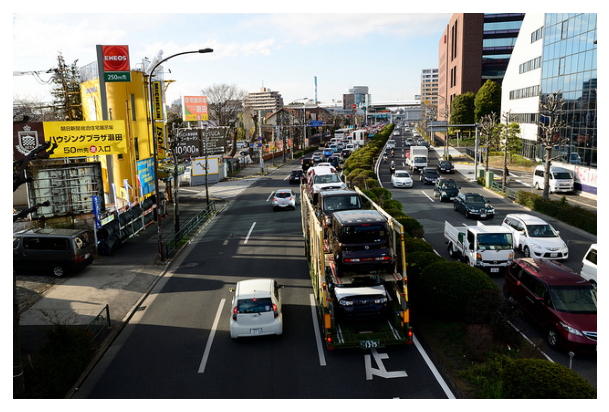

In [6]:
from matplotlib.image import imread

jpg = '/content/Mask_RCNN/images/8053677163_d4c8f416be_z.jpg'
image = imread(jpg) #ダウンロードした画像ファイルを読み込む

#表示する
fig, axes = plt.subplots(1, 1, dpi=32*4)
axes.set_axis_off()
axes.imshow(image)
plt.show()


推論を行う Prediction


Processing 1 images
image                    shape: (424, 640, 3)         min:    0.00000  max:  255.00000  uint8


molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


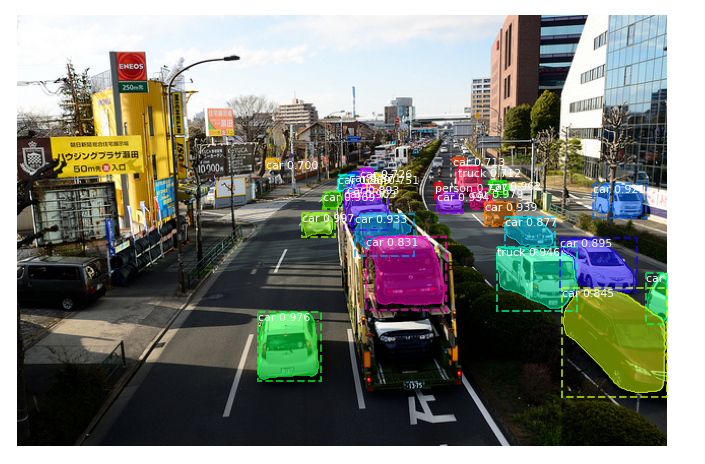

In [7]:
#推論を行う
results = model.detect([image], verbose=1)

# 推論の結果を描画する
'''
rois      : ROI バウンディングボックスの位置
masks     : セグメンテーションマスク
class_ids : クラス番号
scores    : クラス予測の確率 
'''

# 用意されている関数を使って結果を表示
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'], figsize=(12, 12))

破線がバウンディングボックスで，各バウンディングボックスの上部の記述は推論されたクラス名とその予測確率，認識した物体にはセグメンテーションマスクが施されています．

The dashed line shows the bounding box, and the description at the top of each bounding box shows the inferred class name and its predicted probability, and the recognized object is given a segmentation mask.

## Mask R-CNNを使って動画処理 Video Processing Using Mask R-CNN

Mask R-CNNの応用として動画処理をやってみましょう．

まず，認識したい物体のバウンディングの色を固定するために
bounding という関数を用意します．



Let's try video processing as an application of Mask R-CNN.

First, to fix the color of the bounding of the object to be recognized, prepare a function
to fix the bounding color of the object to be recognized.

In [8]:
import cv2

def bounding(image, boxes, class_ids):
    '''
    バウンディングボックスを追加する関数
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    image: RGB image [height, width, 3]
    '''
    # Bounding box
    N = boxes.shape[0]
    for i in range(N):
      class_id = class_ids[i]
      label = class_names[class_id]
      color = (255,255,255)
      if label == 'person': color = (255,0,0)
      if label == 'car': color = (0,255,0)
      if label == 'motorcycle': color = (0,0,255)
      if label == 'bus': color = (255,255,0)
      if label == 'train': color = (255,0,255) 
      if label == 'truck': color = (0,255,255)
      if label =='traffic light': color = (255,125,255)   
      y1, x1, y2, x2 = boxes[i]

      #長方形を描く
      cv2.rectangle(image,(x1,y1),(x2,y2),color,1)
      #テキストを挿入
      #cv2.putText(image, label, (x1, y1+8),
      #         cv2.FONT_HERSHEY_SIMPLEX, 0.3,
      #         color, 1, cv2.LINE_AA)

    return image.astype(np.uint8)



Processing 1 images
image                    shape: (375, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


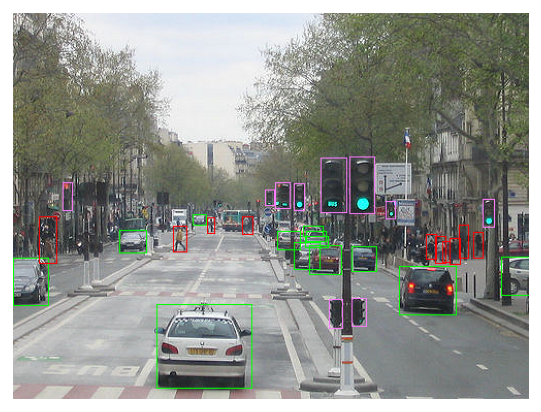

In [9]:
image = imread('/content/Mask_RCNN/images/12283150_12d37e6389_z.jpg')

# 推論を行うと結果が r に格納される
results = model.detect([image], verbose=1)
r = results[0]

# 'rois'はバウンディングボックの位置，'class_ids'はクラス番号
newimage = bounding(image, r['rois'], r['class_ids'])
fig, axes = plt.subplots(1, 1, dpi=32*4)
axes.set_axis_off()
axes.imshow(newimage)
plt.show()

バウンディングボックスとマスクを表示させる関数

A function displaying bounding boxes and masks

In [10]:
import cv2

def bounding_mask(image, boxes, class_ids, masks):
    '''
    バウンディングボックスとマスクを追加する関数
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    image: RGB image [height, width, 3]
    '''
    new_image = image.astype(np.uint8).copy()
    # Bounding box
    N = boxes.shape[0]
    for i in range(N):
      class_id = class_ids[i]
      label = class_names[class_id]
      color = (255,255,255)
      if label == 'person': color = (255,0,0)
      if label == 'car': color = (0,255,0)
      if label == 'motorcycle': color = (0,0,255)
      if label == 'bus': color = (255,255,0)
      if label == 'train': color = (255,0,255) 
      if label == 'truck': color = (0,255,255)
      if label == 'truck': color = (0,255,255)
      if label =='traffic light': color = (255,125,255)      
      y1, x1, y2, x2 = boxes[i]

      #長方形を描く
      cv2.rectangle(new_image,(x1,y1),(x2,y2),color,1)
      #テキストを挿入
      #cv2.putText(new_imag, label, (x1, y1+8),
      #         cv2.FONT_HERSHEY_SIMPLEX, 0.3,
      #         color, 1, cv2.LINE_AA)
      # Mask
      mask = masks[:, :, i]
      new_image = apply_mask(new_image, mask, color)

    return new_image

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c],
                                  image[:, :, c])
    return image



Processing 1 images
image                    shape: (375, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


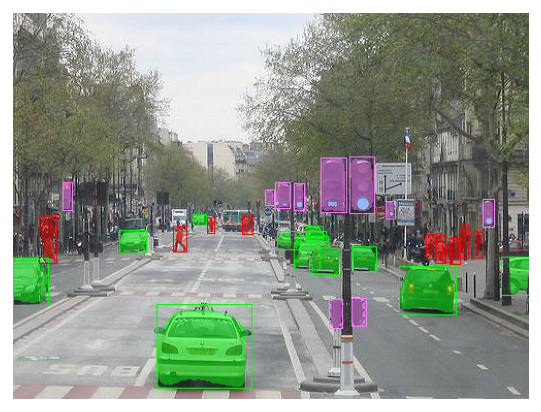

In [11]:
image = imread('/content/Mask_RCNN/images/12283150_12d37e6389_z.jpg')

# 推論を行うと結果が r に格納される
results = model.detect([image], verbose=1)
r = results[0]

# 'rois'はバウンディングボックの位置，'class_ids'はクラス番号，'masks'はマスクのデータ
newimage = bounding_mask(image, r['rois'], r['class_ids'], masks=r['masks'])
fig, axes = plt.subplots(1, 1, dpi=32*4)
axes.set_axis_off()
axes.imshow(newimage)
#plt.savefig('masked.png')
plt.show()

###動画を処理するための関数を用意する Defining a function for processing video

In [12]:
import datetime
import cv2

def bounding_video(model, video_path):
  # Video capture
  vcapture = cv2.VideoCapture(video_path)
  width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = vcapture.get(cv2.CAP_PROP_FPS)

  # Define codec and create video writer
  file_name = "bounding_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
  vwriter = cv2.VideoWriter(file_name,
                            cv2.VideoWriter_fourcc(*'MJPG'),
                            fps, (width, height))

  count = 0
  success = True
  while success:
    if count % 20 == 0: print("frame: ", count)
    # Read next image
    success, image = vcapture.read()
    if success:
      #処理時間の短縮のため5フレームに1回だけ更新する
      if count % 5 == 0:
        # OpenCV returns images as BGR, convert to RGB
        image = image[..., ::-1]
        image = image.astype(np.int32)
        # 推論を行う（この処理が重い）
        r = model.detect([image], verbose=0)[0]
        # bounding
        bdg = bounding(image, r['rois'], r['class_ids'])
        # RGB -> BGR to save image to video
        bdg = bdg[..., ::-1]
      # Add image to video writer
      vwriter.write(np.uint8(bdg))
      count += 1
  vwriter.release()
  print("Saved to ", file_name)

###適当なビデオをダウンロードする Download an appropriate video

ビデオは1秒で30フレームくらいありますので，20秒程度の短いビデオが良いでしょう．
今回はこちらからダウンロードします：http://www1.nhk.or.jp/archives/creative/material/

The video has about 30 frames per second, so a short video of about 20 seconds is appropriate.
In this notebook, we download a video from here: http://www1.nhk.or.jp/archives/creative/material/

In [13]:
!wget -P /content http://www9.nhk.or.jp/das/movie/D0002050/D0002050322_00000_V_000.mp4

--2021-09-25 12:40:39--  http://www9.nhk.or.jp/das/movie/D0002050/D0002050322_00000_V_000.mp4
Resolving www9.nhk.or.jp (www9.nhk.or.jp)... 202.79.241.203, 202.247.51.203, 111.108.184.203, ...
Connecting to www9.nhk.or.jp (www9.nhk.or.jp)|202.79.241.203|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5995860 (5.7M) [video/mp4]
Saving to: ‘/content/D0002050322_00000_V_000.mp4’

D0002050322_00000_V 100%[===================>]   5.72M  6.26MB/s    in 0.9s    

2021-09-25 12:40:42 (6.26 MB/s) - ‘/content/D0002050322_00000_V_000.mp4’ saved [5995860/5995860]



処理が終わったら /content/ というディレクトリに保存されているいるのでダウンロードしてみてください．

In [14]:
%cd /content
bounding_video(model, '/content/D0002050322_00000_V_000.mp4')

/content
frame:  0
frame:  20
frame:  40
frame:  60
frame:  80
frame:  100
frame:  120
frame:  140
frame:  160
frame:  180
frame:  200
frame:  220
frame:  240
frame:  260
frame:  280
frame:  300
frame:  320
frame:  340
frame:  360
frame:  380
frame:  400
frame:  420
frame:  440
frame:  460
frame:  480
frame:  500
frame:  520
frame:  540
frame:  560
frame:  580
frame:  600
frame:  620
frame:  640
frame:  660
frame:  680
frame:  700
frame:  720
frame:  740
Saved to  bounding_20210925T124042.avi
